In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()

In [3]:
def plot_bayes_ls(nk, theta_true, likelihood, mean_X, covinv_X):
    Xs = generate_Xs(nk)
    y = likelihood.func(Xs, theta_true)

    theta_bayes = minimise_bayes(y, likelihood, mean_X, covinv_X, theta_true).x
    theta_ls = minimise_ls(y, likelihood, mean_X, theta_true).x

    plt.plot(Xs, y, 'x', ms=2)
    plt.plot(Xs, likelihood.func(Xs, theta_bayes), label='bayes')
    plt.plot(Xs, likelihood.func(Xs, theta_ls), label='ls')
    plt.legend();
    print(f'bayes: {theta_bayes}')
    print(f'ls: {theta_ls}')
    return Xs, theta_bayes, theta_ls

### **Errorbars on $X$ datapoints**

Start with $\{\log L_i\}$. Get $\theta$ by optimising likelihood, then plot $X_i = f^{-1}(\log L_i, \theta)$ against $\log L_i$ 

Next, plot $\mathrm{E}(X_i)$, with error bars given by square root of diagonal of $\mathrm{Cov(X_i, X_j)}$

Take errors in the predicted $X_i$ to also be $\sqrt{\mathrm{Cov}(X_i, X_i)}$

In [29]:
nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
cov_X = X_Sigma(nk)

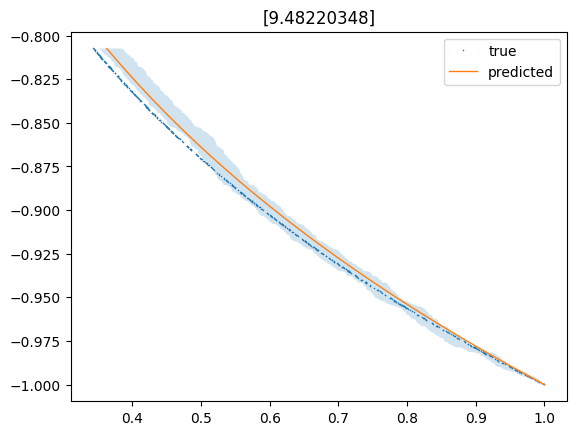

In [102]:
# Simple likelihood
X = generate_Xs(nk)
std_X = np.sqrt(np.diagonal(cov_X))
y = simple.func(X, 10)
theta_b = minimise_bayes(y, simple, mean_X, covinv_X, 10).x
X_b = simple.inverse(y, theta_b)
plt.fill_betweenx(y, mean_X+std_X, mean_X-std_X , alpha=0.2) # mean and variance of X vs logL
# plt.fill_betweenx(y, X_b+std_X, X_b-std_X , alpha=0.2) # mean and variance of X vs logL
plt.plot(X, y, 'x', ms=.5, label='true')
plt.plot(X_b, y, lw=1, label='predicted')
plt.title(theta_b)
plt.legend();

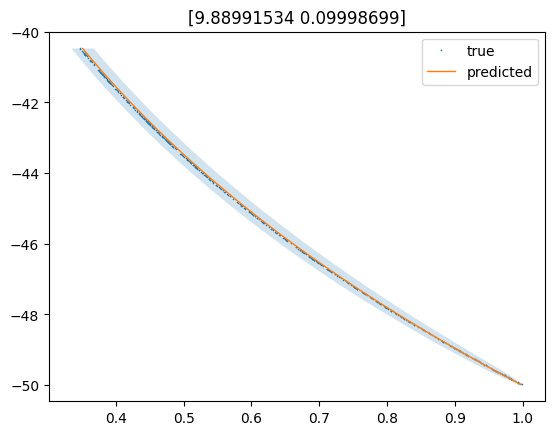

In [88]:
# Middle likelihood
X = generate_Xs(nk)
std_X = np.sqrt(np.diagonal(cov_X))

theta_true = np.array([10, 0.1])
y = middle.func(X, theta_true)
theta_b = minimise_bayes(y, middle, mean_X, covinv_X, theta_true).x
X_b = middle.inverse(y, theta_b)
# plt.fill_betweenx(y, mean_X+std_X, mean_X-std_X , alpha=0.2) # mean and variance of X vs logL
plt.fill_betweenx(y, X_b+std_X, X_b-std_X , alpha=0.2) # mean and variance of X vs logL
plt.plot(X, y, 'x', ms=.5, label='true')
plt.plot(X_b, y, lw=1, label='predicted')
plt.title(theta_b)
plt.legend();

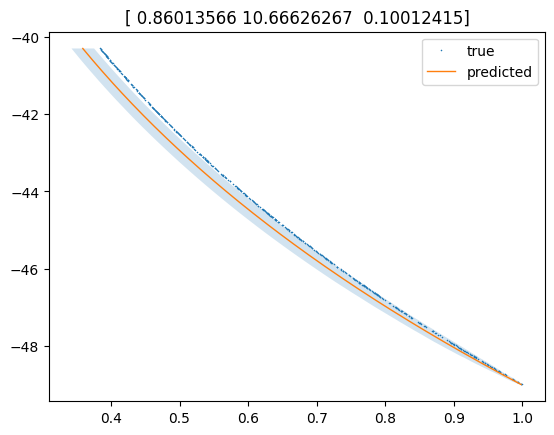

In [46]:
# Full likelihood
X = generate_Xs(nk)
std_X = np.sqrt(np.diagonal(cov_X))
theta_true = np.array([1, 10, 0.1])
y = full.func(X, theta_true)

theta_b = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
X_b = full.inverse(y, theta_b)
# plt.fill_betweenx(y, mean_X+std_X, mean_X-std_X , alpha=0.2) # mean and variance of X vs logL
plt.fill_betweenx(y, X_b+std_X, X_b-std_X , alpha=0.2) # mean and variance of X vs logL
plt.plot(X, y, 'x', ms=.5, label='true')
plt.plot(X_b, y, lw=1, label='predicted')
plt.title(theta_b)
plt.legend();

### **Normalised Cholesky**

Plot in space normalised by Cholesky decomposition 
$$ (\bm{X} - \bm{\mu})^\intercal \Sigma^{-1} (\bm{X} - \bm{\mu}) = |L^{-1}(\bm{X} - \bm{\mu})|^2$$

$$ \Sigma = LL^\intercal,\ \Sigma^{-1} = (L^{-1})^\intercal L^{-1} $$

Least squares errors clearly correlated rather than i.i.d. 

Cholesky removes correlation, but not centered at zero.

In [15]:
nk = 500 * np.ones(2000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
cov_X = X_Sigma(nk)
Linv = np.linalg.cholesky(covinv_X).T

In [24]:
theta_true = np.array([1, 10, 0.1])
X_true = generate_Xs(nk)
y = full.func(X_true, theta_true)

theta_b = minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
theta_g = minimise_gaussian(y, full, mean_X, covinv_X, theta_true).x
theta_l = minimise_ls(y, full, mean_X, theta_true).x
X_b = full.inverse(y, theta_b)
X_g = full.inverse(y, theta_g)
X_l = full.inverse(y, theta_l)
theta_b, theta_l

(array([-2.77822526,  8.84794061,  0.10399537]),
 array([-2.5709554 ,  9.01228509,  0.10396008]))

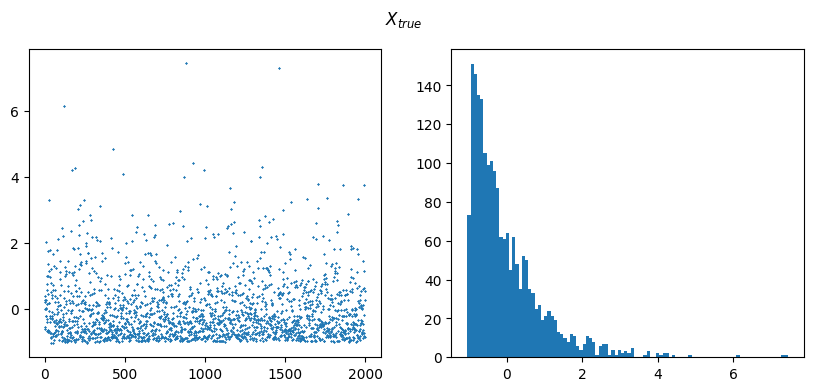

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(Linv @ (X_true - mean_X), 'x', ms=1)
ax2.hist(Linv @ (X_true - mean_X), bins=100)
plt.suptitle('$X_{true}$');

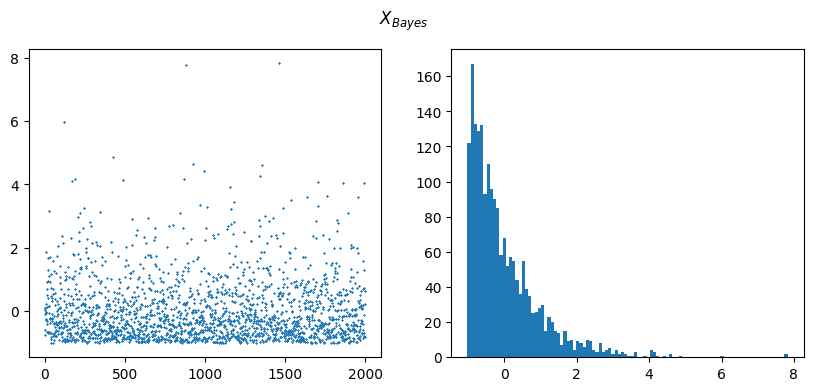

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(Linv @ (X_b - mean_X), 'x', ms=1)
ax2.hist(Linv @ (X_b - mean_X), bins=100);
plt.suptitle('$X_{Bayes}$');

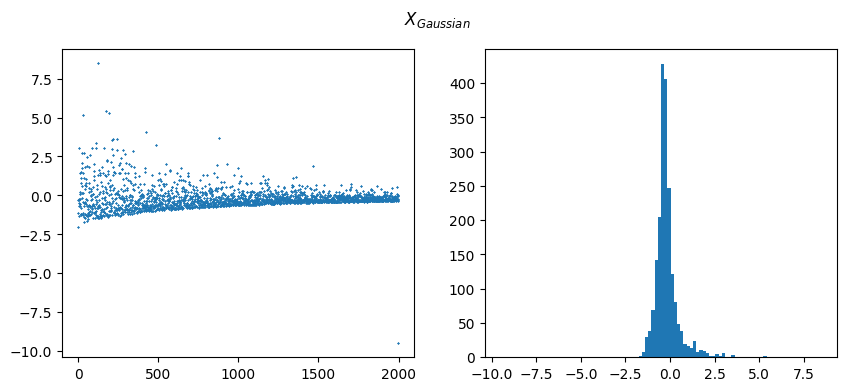

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(Linv @ (X_g - mean_X), 'x', ms=1)
ax2.hist(Linv @ (X_g - mean_X), bins=100);
plt.suptitle('$X_{Gaussian}$');

In [28]:
(Linv @ (X_g - mean_X)).mean()

-0.18635087177983445

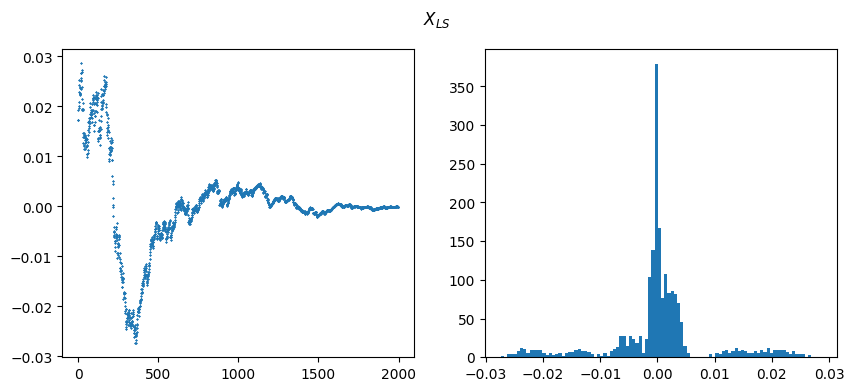

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot((X_l - mean_X), 'x', ms=1)
ax2.hist((X_l - mean_X), bins=100);
plt.suptitle('$X_{LS}$');